# Vehicle damage detection

## Introduction and Project Goal
AI-Based Vehicle Damage Detection and Classification using YOLO.

### Problem Statement
An automated system that detects and classifies vehicle damage from images using transfer learning with YOLOv8.

### Goal/Objective
To finetune a model for identifying the damage parts of a vehicle given image uploaded by the user.

In [1]:
!pip install roboflow ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 88.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


## Dataset Overview and Preparation

Documenting the data ensures reproducibility and transparency.

### Data Source
The data for detection is taken from roboflow
https://universe.roboflow.com/make-and-model-recognition/damage-severity-h7fgy/dataset/1

#### Dataset Size
**Total Image count**: 2000 Images

**Training dataset**: 1400 Images

**classes**: car-part-crack, detachment, flat-tire, glass-crack, lamp-crack, minor-deformation, moderate-deformation, paint-chips, scratches, severe-deformation, side-mirror-crack

**Data Preprocessing**

Auto-Orient: Applied

Resize: Stretch to 640x640

**Augmentations**: No augmentations were applied

In [2]:
from roboflow import Roboflow
import os

from google.colab import userdata

# This line is onlt specific to Google Colab for reteriving the key from secret
ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
WORKSPACE_ID = "make-and-model-recognition"
PROJECT_ID = "damage-severity-h7fgy"
VERSION_NUMBER = 1
DATASET_FORMAT = "yolov8"

rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace(WORKSPACE_ID).project(PROJECT_ID)

dataset_version = project.version(VERSION_NUMBER)

print(f"Successfully connected to project: {PROJECT_ID} (Version {VERSION_NUMBER})")

loading Roboflow workspace...
loading Roboflow project...
Successfully connected to project: damage-severity-h7fgy (Version 1)


In [3]:
DOWNLOAD_DIR = "car_damage_dataset_yolov8"

dataset_info = dataset_version.download(
    model_format="yolov8",
    location=DOWNLOAD_DIR
)



Extracting Dataset Version Zip to car_damage_dataset_yolov8 in yolov8:: 100%|██████████| 4012/4012 [00:00<00:00, 6615.39it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
data_yaml_path = os.path.join(DOWNLOAD_DIR, 'data.yaml')

print("Dataset Download Complete!")
print(f"Data saved to: {os.path.abspath(DOWNLOAD_DIR)}")
print(f"YOLOv8 Configuration file (data.yaml) ready at: {data_yaml_path}")

Dataset Download Complete!
Data saved to: /content/car_damage_dataset_yolov8
YOLOv8 Configuration file (data.yaml) ready at: car_damage_dataset_yolov8/data.yaml


## Loading Pre-trained Model Weights (Transfer Learning)
Using 'yolov8s.pt' (Small) for small size and high speed.

> Previously this was tried with a nano version. It resulted in good indicator for 3 classes flat-tire: (mAP50: 0.959, mAP50-95: 0.823), glass-crack: (mAP50: 0.966, mAP50-95: 0.838), lamp-crack: (mAP50: 0.671, mAP50-95: 0.498). But failed to perform well for the other classes. To mitigate this I used a larger model (small). It has more parameters (72 layers, 11M parameters) and hence might achieve higher accuracy



### Finetuning the Yolov8 model by freezing the backbone layers of the model

![YOLOv8 Architecture](https://yolov8.org/wp-content/uploads/2024/01/What-is-YOLOv8-1.webp)
*Image of YOLOv8 taken from the Ultralytics website*

The reason behind freezing is that the initial layers have already learned fundamental features (edges, textures, colors) from a massive dataset, and these features are useful for detecting damage to vehicle as it also involves detecting edges, texture of the vehicle and the color of the vehicle. I only want to train the final layers to adapt the general features to specific damage classes.

In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8s.pt')

print("Starting YOLOv8 Fine-Tuning...")

results = model.train(
    data='/content/car_damage_dataset_yolov8/data.yaml',
    epochs=100,
    imgsz=640,
    batch=64,
    name='damage_detector_v1',
    patience=20,
    optimizer='AdamW',
    freeze=10
    )

best_weights_path = 'runs/detect/damage_detector_v1/weights/best.pt'

Starting YOLOv8 Fine-Tuning...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/car_damage_dataset_yolov8/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=damage_detector_v12, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap

I ran the model for 100 epoch with 10 freeze layers.

## Load the Best Trained Model to Validate

In [ ]:

best_model = YOLO("/content/runs/detect/damage_detector_v1/weights/best.pt")

print("Running final model validation...")
metrics = best_model.val()

mAP50 = metrics.box.map50
mAP50_95 = metrics.box.map

precision = metrics.box.p[0] if metrics.box.p is not None and len(metrics.box.p) > 0 else 0.0
recall = metrics.box.r[0] if metrics.box.r is not None and len(metrics.box.r) > 0 else 0.0
f1_score = metrics.box.f1[0] if metrics.box.f1 is not None and len(metrics.box.f1) > 0 else 0.0

print(f"\n--- Model Evaluation Results ---")
print(f"Overall mAP (0.50-0.95): {mAP50_95 * 100:.2f}%")
print(f"mAP50: {mAP50 * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1_score * 100:.2f}%")
print(f"PRD Target (89%+): {'MET' if mAP50_95 >= 0.89 else 'MISSED'}")

Running final model validation...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 20.1±10.9 MB/s, size: 50.6 KB)
val: Scanning /content/car_damage_dataset_yolov8/valid/labels.cache... 400 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 400/400 826.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 25/25 2.4it/s 10.4s
                   all        400        943      0.263      0.122     0.0419     0.0141
        car-part-crack         62         92     0.0597     0.0217     0.0191     0.0059
            detachment          9         10          0          0    0.00083   0.000397
             flat-tire         31         32     0.0703      0.438     0.0809     0.0241
           glass-crack         79         80      0.201       0.15     0.0876     0.0

In [ ]:
from collections import Counter
input_image_path = '/content/car_damage_dataset_yolov8/test/images/000029_jpg.rf.9621e9b41448b0b045421c8d31873d46.jpg'

print("\nRunning Inference and Damage Counting...")
inference_results = best_model.predict(
    source=input_image_path,
    conf=0.50,
    iou=0.7,
    save=True
)

damage_count = Counter()

for result in inference_results:
    detected_class_ids = result.boxes.cls.int().tolist()

    class_names = result.names

    class_id_counts = Counter(detected_class_ids)

    for class_id, count in class_id_counts.items():
        damage_name = class_names[class_id]
        damage_count[damage_name] += count

print("\n--- Final Damage Count Report ---")
if not damage_count:
    print("No damage detected above the confidence threshold.")
else:
    for damage, count in damage_count.items():
        print(f"Detected: {count} instance(s) of '{damage}'")



Running Inference and Damage Counting...

image 1/1 /content/car_damage_dataset_yolov8/test/images/000029_jpg.rf.9621e9b41448b0b045421c8d31873d46.jpg: 640x640 20 lamp-cracks, 5 moderate-deformations, 16.7ms
Speed: 2.2ms preprocess, 16.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict

--- Final Damage Count Report ---
Detected: 20 instance(s) of 'lamp-crack'
Detected: 5 instance(s) of 'moderate-deformation'


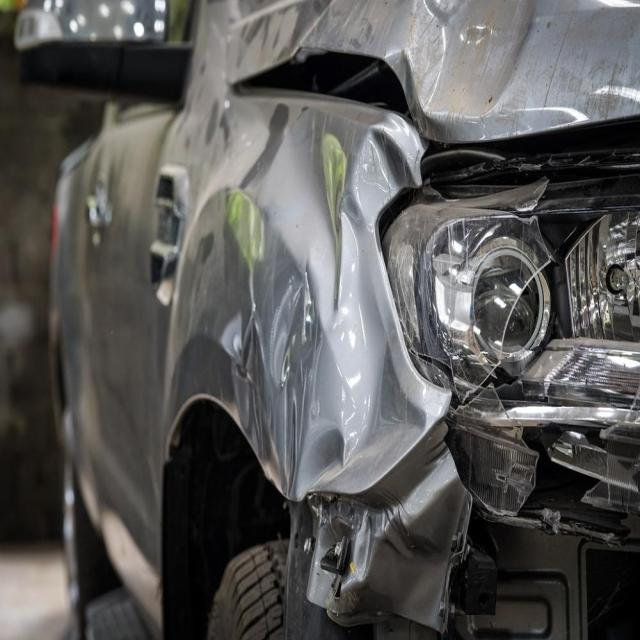

In [ ]:
from IPython.display import Image
Image(input_image_path)

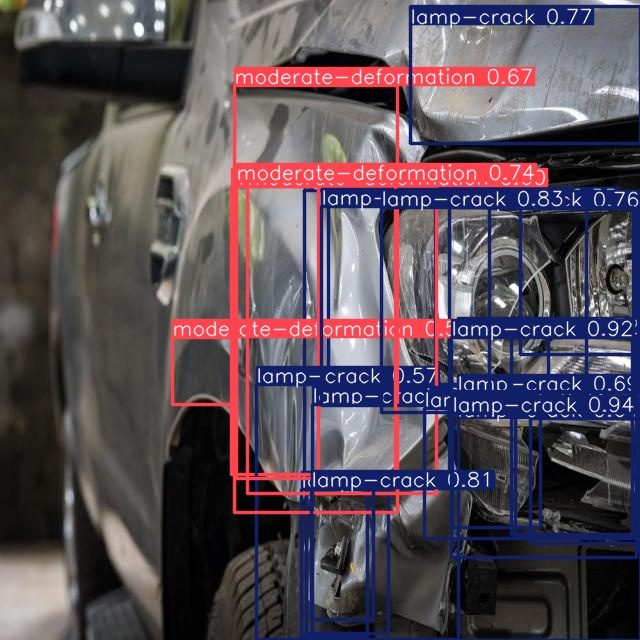

In [ ]:
Image('/content/runs/detect/predict/000029_jpg.rf.9621e9b41448b0b045421c8d31873d46.jpg')

The same was tried for YOLOv8n but there are significant performance improvement in identifying class specific to vehicle damage.

**scratches**: mAP50 increased from 0.349(YOLOv8n) to 0.359. Precision jumped from 0.477(YOLOv8n) to 0.377. While precision slightly dipped, the Recall is higher and the mAP50 is slightly better.

**moderate-deformation**: mAP50 increased from 0.315(YOLOv8n) to 0.370. A gain which shows the larger model is better at recognizing this kind of damage.

**car-part-crack**: mAP50 increased from 0.0636(YOLOv8n) to 0.164. Over 150% improvement which indicates the model is finally starting to recognize this complex damage.

Other classes like

**minor-deformation**: mAP50 0.0642. Recall is 8.6%.

**paint-chips**: mAP50 0.13. Recall is 15.8%.

To overcome the shortcomings I decided to unfreeze the best fit model weights and train over longer epoch. This can refine the model.

## Fine tune models by unfreezing all layers

In [5]:
from ultralytics import YOLO

BEST_FROZEN_WEIGHTS = '/content/best (1).pt'
model = YOLO(BEST_FROZEN_WEIGHTS)

print("\nPhase 2: Training ALL layers (Unfrozen Refinement)...")

results = model.train(
    data=data_yaml_path,
    imgsz=640,
    batch=64,
    epochs=200,
    freeze=0,
    name="phase2_unfrozen_refinement"
)

print("\nPhase 2 refinement training started. This should lead to further improvements, especially in subtle classes.")


Phase 2: Training ALL layers (Unfrozen Refinement)...
Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=car_damage_dataset_yolov8/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/best (1).pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=phase2_unfrozen_refinement, nbs=64, nms=False, opset=None, optimize=

## Model Evaluation After Unfreezing all Layers

In [8]:
print("\n--- Model Evaluation Results ---")
print(f"Overall mAP (0.50-0.95): {metrics.box.map: .4f}")
print(f"mAP50: {metrics.box.map50: .4f}")

print("\n--- Class-Specific mAP50 Results ---")
if metrics.box.maps is not None:
    for i, name in enumerate(metrics.names):
        if len(metrics.box.ap50) > i:
             print(f"  {name}: {metrics.box.ap50[i]: .4f}")
        else:
             print(f"  {name}: NA")

print(f"\nMean Precision (P): {metrics.box.mp: .4f}")
print(f"Mean Recall (R): {metrics.box.mr: .4f}")


--- Model Evaluation Results ---
Overall mAP (0.50-0.95):  0.2968
mAP50:  0.4045

--- Class-Specific mAP50 Results ---
  0:  0.2640
  1:  0.0031
  2:  0.9110
  3:  0.9842
  4:  0.7034
  5:  0.1159
  6:  0.4333
  7:  0.1354
  8:  0.3649
  9:  0.1764
  10:  0.3574

Mean Precision (P):  0.5190
Mean Recall (R):  0.3896


#### Comparison and interpretation of the result

There is a significant improvement in the model after the second round of training.

mAP50-95 improved from 24.7%(freeze) to 29.7% which shows that the model is better in making precise bounding boxes at IoU thresholds.

mAP50 improved from	34.7%	to 40.4% which shows it is better at finding and locating the damage in the vehicle.

Precision improved from	41.6%	to 51.9% which shows that false positives are reduced.

Recall increased from	34.3%	to 39.0% shows that the model is less likely to miss the damage in the vehicle.


#### Class wise breakdown after training

|Class Name          |Instances|Phase 1 mAP50|Phase 2 mAP50|Change      |Insight                                                                                                                                                                                                                   |
|--------------------|---------|-------------|-------------|------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|glass-crack         |80       |0.969        |0.984        |↑1.5%       |Near-perfect. (P=0.974, R=0.947)                                                                                                                                                                                          |
|flat-tire           |32       |0.908        |0.911        |↑0.3%       |Excellent.                                                                                                                                                                                                                |
|lamp-crack          |68       |0.694        |0.703        |↑0.9%       |                                                                                                                                           |
|moderate-deformation|180      |0.370        |0.433        |↑6.3%       |Very The model can now reliably find moderate damage.                                                                                                                                                 |
|scratches           |302      |0.359        |0.365        |↑0.6%       |Modest gain. This complex class needs more training or data.                                                                                                                                                              |
|car-part-crack      |92       |0.164        |0.264        |↑100 points!|The model can now consistently identify complex cracks in the vehicle.                                                                                                                                                     |
|paint-chips         |76       |0.132        |0.135        |↑0.3%       |Slight gain. Still difficult due to small size/texture.                                                                                                                                                                   |
|severe-deformation  |18       |0.137        |0.176        |↑3.9%       | low instances.                                                                                                                                                                                      |
|minor-deformation   |81       |0.0642       |0.116        |↑5.2 points!|Significant percentage gain, but still low.                                                                                                 |                                                                                                                                                                                       |
|side-mirror-crack   |4        |0.0189       |0.499        |↑48.0%      |This might be an anomaly.|
